# CONVERSION TIME PREDICTIONS FOR ACD/ACO PLAYERS USING SURVIVAL ANALYSIS

## Data processing
data is imported from snowflake than cleaned and scaled to be modeled in a survival network

### Librairy imports

In [8]:
%matplotlib inline
import pandas as pd 
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.ndimage import gaussian_filter1d
from datetime import datetime
import dill as pickle
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from os import listdir
from os.path import isfile, join

# pip install "snowflake-connector-python[pandas]"
# pip install "snowflake-connector-python[secure-local-storage,pandas]"
import snowflake.connector
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import serialization

#from sqlalchemy import create_engine
#from snowflake.sqlalchemy import URL
#from snowflake.connector import connect
#from snowflake.connector.pandas_tools import write_pandas

from lifelines import utils
from lifelines import KaplanMeierFitter, CoxPHFitter, CoxTimeVaryingFitter, AalenAdditiveFitter
from lifelines.utils import concordance_index
from lifelines.calibration import survival_probability_calibration

import optuna

from pycox.utils import kaplan_meier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper
import torch
import torchtuples as tt
from pycox.datasets import metabric
from pycox.models import CoxTime
from pycox.models.cox_time import MLPVanillaCoxTime
from pycox.evaluation import EvalSurv
from pycox.models import CoxPH, CoxCC

/home/csouvigny/.conda/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
def get_data(query):
    with open("/home/shared/csouvign/rsa_key.p8", "rb") as key:
        p_key= serialization.load_pem_private_key(
            key.read(),
            password='2B@XS5E&!5%UCab'.encode(),
        )

    pkb = p_key.private_bytes(
        encoding=serialization.Encoding.DER,
        format=serialization.PrivateFormat.PKCS8,
        encryption_algorithm=serialization.NoEncryption())

    ctx = snowflake.connector.connect(
        user='camille.souvigny@ubisoft.com',
        account='ubisoft.us-east-1',
        private_key=pkb,
        warehouse='EMEA_ANALYTICS_COMMON',
        database='SANDBOX',
        schema='EMEA_ANALYTICS_CRM_PRIVATE',
        role='SNK_F_EMEAANALYTICS_CRM_SB_DEV',
        proxy_host='http://proxy.ubisoft.org',
        proxy_port='3128'
        )
    try:
        cur = ctx.cursor().execute(query)
        df = cur.fetch_pandas_all()
    except:
        df = pd.DataFrame.from_records(iter(cur), columns=[x[0] for x in cur.description])
    finally:
        cur.close()
        print("successfull closed connection")
    ctx.close()
    return df


def pb_at_conv(x):
    #return  nb_covariate -1 + int(x.TEND) - 30
    try :
        return x[int(x.CONVERSION_DAYS_ACV)]
    except :
        return np.nan
    
def pb_at_conv_moins1M(x):
    try :
        return x[int(x.CONVERSION_DAYS_ACV) - 30]
    except :
        return np.nan
    
def pb_at_conv_plus1M(x):
    try:
        return x[int(x.CONVERSION_DAYS_ACV) + 30 ]
    except :
        return np.nan

def pb_at_conv_plus10D(x):
    try:
        return x[int(x.CONVERSION_DAYS_ACV) + 10 ]
    except :
        return np.nan
    
def pred_AC_survival(pred_set, test_set):
    pred_set['pb_conv']=pred_set.apply(pb_at_conv, axis=1)
    pred_set['pb_conv_moins1M']=pred_set.apply(pb_at_conv_moins1M, axis=1)
    pred_set['pb_conv_plus1M']=pred_set.apply(pb_at_conv_plus1M , axis=1)
    pred_set['pb_conv_plus10D']=pred_set.apply(pb_at_conv_plus10D, axis=1)
    return pred_set

### Import and data cleaning

dataset query is stored in a SANDBOX.EMEA_ANALYTICS_CRM_PRIVATE.CS_AC_P2_PLAYERS_CONVERSION_ON_ACV view (running the view takes some time).
current_date_key must be defined at the time we want to stop the analysis

In [10]:
def data_cleaning(df):
    df[list(df.drop(['USER_KEY','CLUSTER_2021','CLUSTER_2022','P2_LAST_OWNED'], axis=1).select_dtypes(include = ['object']).columns)] = df[list(df.drop(['USER_KEY','CLUSTER_2021','CLUSTER_2022','P2_LAST_OWNED'], axis=1).select_dtypes(include=['object']).columns)].astype(float)
    df.SENIORITY_WHEN_CONV_TO_LAST_OWNED[df.SENIORITY_WHEN_CONV_TO_LAST_OWNED.isna()] = df.SENIORITY_LAST_OWNED[df.SENIORITY_WHEN_CONV_TO_LAST_OWNED.isna()]
    mean_playtime_one_pd = df[df.LAST_OWNED_PLAYTIME>=0][df.NB_PD_LAST_OWNED==1].LAST_OWNED_PLAYTIME.mean()
    df.loc[df[df.LAST_OWNED_PLAYTIME.isna()].index,'LAST_OWNED_PLAYTIME'] = mean_playtime_one_pd
    fill_zero={  
            'LAST_OWNED_PLAYTIME_10D'        : 0
           , 'PLAYTIME_LAST_OWNED_10D_RATIO' : 0
           , 'MIN_P2_PLAYTIME_10D'           : 0
           , 'MAX_P2_PLAYTIME_10D'           : 0
           , 'AVG_P2_PLAYTIME_10D'           : 0
           , 'SUM_P2_PLAYTIME_10D'           : 0
           , 'MIN_AC_PLAYTIME_10D'           : 0
           , 'MAX_AC_PLAYTIME_10D'           : 0
           , 'AVG_AC_PLAYTIME_10D'           : 0
           , 'SUM_AC_PLAYTIME_10D'           : 0
           , 'MIN_PLAYTIME_10D_RATIO'        : 0 
           , 'AVG_PLAYTIME_10D_RATIO'        : 0
           , 'MAX_PLAYTIME_10D_RATIO'        : 0 
           , 'MIN_P2_PLAYTIME'               : 0                   
           , 'MAX_P2_PLAYTIME'               : 0                   
           , 'AVG_P2_PLAYTIME'               : 0                   
           , 'SUM_P2_PLAYTIME'               : 0
           , 'MIN_AC_PLAYTIME'               : 0
           , 'MAX_AC_PLAYTIME'               : 0
           , 'AVG_AC_PLAYTIME'               : 0
           , 'SUM_AC_PLAYTIME'               : 0
           , 'AC_DLC'                        : 0
           , 'AC_P2_DLC'                     : 0 
           , 'AC_CURRENCY'                   : 0
           , 'AC_P2_CURRENCY'                : 0 
           , 'AC_SEASONPASS'                 : 0 
           , 'AC_P2_SEASONPASS'              : 0 
           , 'NB_ACTIVATION_PASS'            : 0
           , 'PD_FW'                         : 0
           , 'PD_AC_FW'                      : 0 
           , 'PD_P2_FW'                      : 0 
           , 'PD_ACV_FW'                     : 0
           , 'PD_AC_OB'                      : 0 
           , 'PD_P2_OB'                      : 0
           , 'PD_TRIAL'                      : 0
    }
    df = df.fillna(value=fill_zero)
    df = df.dropna(subset=['RECENCY_LAST_OWNED',
                           'SENIORITY_LAST_OWNED',
                           'NB_AC', 'PLAYED_ORIGINS',
                           'ESTIM_BG','ESTIM_NET_BG',
                           'PL_ACQUI', 'PL_NET_ACQUI',
                            'P2_LAST_OWNED' ])
    
    df["P2_LAST_OWNED_ASSASSIN'S CREED ODYSSEY"] =  df.P2_LAST_OWNED.apply(lambda x: 1 if x == "ASSASSIN'S CREED ODYSSEY" else 0)
    df = df.drop(["P2_LAST_OWNED"], axis=1)
    return df

In [11]:
get_data('''set current_date_key=20220701; ''')

successfull closed connection


,status
0,Statement executed successfully.


In [12]:
#AC = get_data ('''  select * from CS_AC_P2_PLAYERS_CONVERSION_ON_ACV sample(10); ''')
start_time = datetime.now()
AC = get_data('''
    WITH CTE AS (
     SELECT 
      *,
       ROW_NUMBER() OVER(PARTITION BY CONVERTED_VALHALLA 
                         ORDER BY RANDOM() ) AS start_order 
        FROM SANDBOX.EMEA_ANALYTICS_CRM_PRIVATE.CS_AC_P2_PLAYERS_CONVERSION_MODEL_ON_ACV 
        )
        SELECT 
        *
        FROM CTE
        WHERE start_order <= (select count(*) * 1/100 from CTE);
''')

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

AC = data_cleaning(AC)
print('missing values : ', np.any(np.isnan(AC.drop(['USER_KEY','CLUSTER_2021','CLUSTER_2022'], axis=1))))
print('all finite values : ', np.all(np.isfinite(AC.drop(['USER_KEY','CLUSTER_2021','CLUSTER_2022'], axis=1))))

successfull closed connection
Duration: 0:00:41.206637


/tmp/ipykernel_297/2589744841.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.SENIORITY_WHEN_CONV_TO_LAST_OWNED[df.SENIORITY_WHEN_CONV_TO_LAST_OWNED.isna()] = df.SENIORITY_LAST_OWNED[df.SENIORITY_WHEN_CONV_TO_LAST_OWNED.isna()]
/tmp/ipykernel_297/2589744841.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mean_playtime_one_pd = df[df.LAST_OWNED_PLAYTIME>=0][df.NB_PD_LAST_OWNED==1].LAST_OWNED_PLAYTIME.mean()


missing values :  False
all finite values :  True


In [13]:
test_last_month = get_data('''
    with t as (select  AC.*
           , TO_DATE((TO_CHAR(PR.FIRST_PLAYED_DATE_KEY)),'YYYYMMDD') - TO_DATE((TO_CHAR(20201110)),'YYYYMMDD') +1 as acv_acqui_delay_valid

    from SANDBOX.EMEA_ANALYTICS_CRM_PRIVATE.CS_AC_P2_PLAYERS_CONVERSION_MODEL_ON_ACV AC
        inner join UBICENTRAL.PLAY_SHARED.VW_AGG_FT_USER_PRODUCT PR
            on PR.USER_KEY=AC.USER_KEY
        inner join UBICENTRAL.PLAY_SHARED.VW_DIM_GENOME_DENORMALIZED_ACTIVE G 
            on G.GENOME_KEY=PR.GENOME_KEY
    where CONVERTED_VALHALLA=0 
        and  INSTALLMENT_DESCRIPTION like '%ASSASSIN%VALHALLA%' 
        and PR.CALCULATED_GAME_RELEASE_KEY=5
        and FIRST_PLAYED_DATE_KEY > 20220701
        and number_played_days > 0
        QUALIFY RANK() OVER (PARTITION BY AC.USER_KEY ORDER BY PR.FIRST_PLAYED_DATE_KEY ASC)=1 
        )
        
 select *
 from t sample (20);
''')

test_last_month = data_cleaning(test_last_month)

successfull closed connection


/tmp/ipykernel_297/2589744841.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.SENIORITY_WHEN_CONV_TO_LAST_OWNED[df.SENIORITY_WHEN_CONV_TO_LAST_OWNED.isna()] = df.SENIORITY_LAST_OWNED[df.SENIORITY_WHEN_CONV_TO_LAST_OWNED.isna()]
/tmp/ipykernel_297/2589744841.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mean_playtime_one_pd = df[df.LAST_OWNED_PLAYTIME>=0][df.NB_PD_LAST_OWNED==1].LAST_OWNED_PLAYTIME.mean()


In [14]:
n_censored = AC.shape[0] - AC.CONVERTED_VALHALLA.sum()
print((AC.shape[0]), "records")
print("%.1f%% of records are censored" % (n_censored / AC.shape[0] * 100))

553578 records
47.5% of records are censored


### Scale covariate and create input for NN

In [15]:
def input_preparation(df, df_futur_conversion_to_predict):
    df_train = df
    df_test = df_train.sample(frac=0.2)
    df_train = df_train.drop(df_test.index)
    df_val = df_train.sample(frac=0.2)
    df_train = df_train.drop(df_val.index)
    censored_test = df_test[df_test.CONVERTED_VALHALLA == 0]
    cols_std = ['CONV_LAST_OWNED',
               'P2_POST_LAUNCH_ARRIVAL',
               'NB_AC', 'SENIORITY_AC',
               'RECENCY_AC', 'LIFETIME_AC', 'RECENCY_LAST_OWNED',
               'SENIORITY_LAST_OWNED', 'SENIORITY_P2', 'RECENCY_P2', 'NB_PD_AC',
               'NB_PD_AC_2021', 'NB_PD_AC_2022', 'NB_PD_P2', 'NB_PD_LAST_OWNED',
               'PROP_ACOD_AC', 'AVG_PD_P2', 'PROP_MOST_AC', 'PROP_LEAST_AC',
               'AVG_PD_AC', 'SENIORITY_WHEN_CONV_TO_LAST_OWNED', 'MIN_P2_LIFETIME',
               'MAX_P2_LIFETIME', 'AVG_P2_LIFETIME', 'MIN_LIFETIME_AC',
               'MAX_LIFETIME_AC', 'AVG_LIFETIME_AC', 'MIN_P2_ACQ_DELAY',
               'MAX_P2_ACQ_DELAY', 'AVG_P2_ACQ_DELAY', 'MIN_AC_ACQ_DELAY',
               'MAX_AC_ACQ_DELAY', 'AVG_AC_ACQ_DELAY', 'NB_GAMES', 'NB_BRANDS',
               'NB_GAMES_2022', 'SENIORITY', 'RECENCY', 'NB_PD', 'NB_PD_2021',
               'NB_PD_2022', 'PROP_SD_GAMES', 'PROP_MOST_GAME', 'AVG_PD',
               'PROP_LEAST_GAME', 'MIN_LIFETIME',  'MAX_LIFETIME', 'AVG_LIFETIME', 'SD_LAST_OWNED_10D',
               'SD_RATIO_LAST_OWNED_10D', 'MIN_P2_SD_10D', 'MAX_P2_SD_10D',
               'AVG_P2_SD_10D', 'MIN_AC_SD_10D', 'MAX_AC_SD_10D', 'AVG_AC_SD_10D',
               'MIN_P2_SD_RATIO_10D', 'MAX_P2_SD_RATIO_10D', 'AVG_P2_SD_RATIO_10D',
               'MIN_AC_SD_RATIO_10D', 'MAX_AC_SD_RATIO_10D', 'AVG_AC_SD_RATIO_10D',
               'MIN_P2_SD_1M', 'MAX_P2_SD_1M', 'AVG_P2_SD_1M', 'MIN_AC_SD_1M',
               'MAX_AC_SD_1M', 'AVG_AC_SD_1M', 'MIN_P2_SD_RATIO_1M',
               'MAX_P2_SD_RATIO_1M', 'AVG_P2_SD_RATIO_1M', 'MIN_AC_SD_RATIO_1M',
               'MAX_AC_SD_RATIO_1M', 'AVG_AC_SD_RATIO_1M', 'LAST_OWNED_PLAYTIME',
               'LAST_OWNED_PLAYTIME_10D', 'PLAYTIME_LAST_OWNED_10D_RATIO',
               'MIN_P2_PLAYTIME', 'MAX_P2_PLAYTIME', 'AVG_P2_PLAYTIME',
               'SUM_P2_PLAYTIME', 'MIN_P2_PLAYTIME_10D', 'MAX_P2_PLAYTIME_10D',
               'AVG_P2_PLAYTIME_10D', 'SUM_P2_PLAYTIME_10D', 'MIN_AC_PLAYTIME',
               'MAX_AC_PLAYTIME', 'AVG_AC_PLAYTIME', 'SUM_AC_PLAYTIME',
               'MIN_AC_PLAYTIME_10D', 'MAX_AC_PLAYTIME_10D', 'AVG_AC_PLAYTIME_10D',
               'SUM_AC_PLAYTIME_10D', 'MIN_PLAYTIME_10D_RATIO',
               'AVG_PLAYTIME_10D_RATIO', 'MAX_PLAYTIME_10D_RATIO', 'LEVEL_LAST_OWNED', 'PD_FW', 'PD_AC_FW',
               'PD_P2_FW', 'PD_ACV_FW', 'PD_AC_OB', 'PD_P2_OB', 'PD_TRIAL',
               'NB_ACTIVATION_PASS', 'AC_DLC', 'AC_P2_DLC', 'AC_CURRENCY',
               'AC_P2_CURRENCY', 'AC_SEASONPASS', 'AC_P2_SEASONPASS', 'ESTIM_BG',
               'ESTIM_NET_BG', 'PL_ACQUI', 'PL_NET_ACQUI',
           ]
    
    cols_bin = ["P2_LAST_OWNED_ASSASSIN'S CREED ODYSSEY",
                "PLAYED_ORIGINS", "PLAYED_ODYSSEY"] 

    standardize = [([col], StandardScaler()) for col in cols_std]
    leave = [(col, None) for col in cols_bin]

    x_mapper_float = DataFrameMapper(standardize + leave)

    x_train = x_mapper_float.fit_transform(df_train).astype('float32')
    x_val = x_mapper_float.transform(df_val).astype('float32')
    x_test = x_mapper_float.transform(df_test).astype('float32')
    x_to_predict = x_mapper_float.transform(df_futur_conversion_to_predict).astype('float32')
    x_censored_test = x_mapper_float.transform(censored_test).astype('float32')
    
    labtrans = CoxTime.label_transform() # standardize durations
    get_target = lambda df: (df['CONVERSION_DAYS_ACV'].values, df['CONVERTED_VALHALLA'].values)
    y_train = labtrans.fit_transform(*get_target(df_train))
    y_val = labtrans.transform(*get_target(df_val))
    durations_test, events_test = get_target(df_test)
    val = tt.tuplefy(x_val, y_val)
    
    return df_train, df_test, x_train, x_val, x_test, x_to_predict, x_censored_test, y_train, y_val, durations_test, events_test, val, labtrans

In [16]:
df_train, df_test, x_train, x_val, x_test, x_to_predict, x_censored_test, y_train, y_val, durations_test, events_test, val, labtrans = input_preparation(AC, test_last_month)

## Kaplan Meyer estimates
look at conversion rate through time per cohorts

### Conversion rate through time

Text(0.5, 0, 'Time (days)')

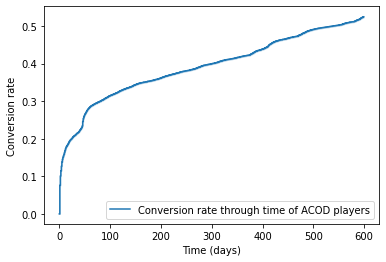

In [17]:
kmf = KaplanMeierFitter()
kmf.fit(durations = AC.CONVERSION_DAYS_ACV, event_observed = AC.CONVERTED_VALHALLA)
kmf.plot_cumulative_density(label='Conversion rate through time of ACOD players')
plt.ylabel('Conversion rate')
plt.xlabel('Time (days)')

### Conversion rate through time per cohorts of continuous of categorical variables

Text(0.5, 0, 'Time (days)')

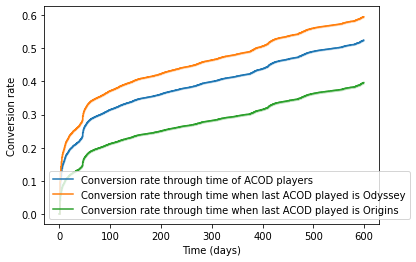

In [18]:
kmf = KaplanMeierFitter()
kmf.fit(durations = AC.CONVERSION_DAYS_ACV, event_observed = AC.CONVERTED_VALHALLA)
kmf.plot_cumulative_density(label='Conversion rate through time of ACOD players')

kmf2 = KaplanMeierFitter()
kmf2.fit(durations = AC[AC["P2_LAST_OWNED_ASSASSIN'S CREED ODYSSEY"] ==1].CONVERSION_DAYS_ACV, event_observed = AC[AC["P2_LAST_OWNED_ASSASSIN'S CREED ODYSSEY"] ==1].CONVERTED_VALHALLA)
kmf2.plot_cumulative_density(label='Conversion rate through time when last ACOD played is Odyssey')


kmf3 = KaplanMeierFitter()
kmf3.fit(durations = AC[AC["P2_LAST_OWNED_ASSASSIN'S CREED ODYSSEY"] == 0].CONVERSION_DAYS_ACV, event_observed = AC[AC["P2_LAST_OWNED_ASSASSIN'S CREED ODYSSEY"] == 0].CONVERTED_VALHALLA)
kmf3.plot_cumulative_density(label='Conversion rate through time when last ACOD played is Origins')
plt.ylabel('Conversion rate')
plt.xlabel('Time (days)')

## Non linear Cox Models

Cox model minimizes log-likelihod by using Newton-Raphson's method
Here, Pycox Neural Networks uses mini-batch stochastic gradient descent to better scale large datasets.

get_target = lambda df: (df['CONVERSION_DAYS_ACV'].values, df['CONVERTED_VALHALLA'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
durations_to_predict, events_to_predict = get_target(test_last_month)
val = x_val, y_val

def tuple_from_array(x):
    return tuple(x)
y_train = np.array(pd.DataFrame(y_train).apply(tuple_from_array , axis=1))
a,b= tt.tuplefy(x_train, y_train).to_numpy()

import os
onlyfiles = [f for f in listdir("/home/shared/csouvign/") if isfile(join("/home/shared/csouvign/", f))]

hyper_results = {}

start_time = datetime.now()

for f_name in onlyfiles: 
    if "class 'torchtuples." in f_name :
        os.remove(f_name)
        

### Network Tuning with Optuna

In [1]:
# Non linear Coc model with proportional hazard
def objective_coxcc(trial):
    in_features = x_train.shape[1]
    out_features = 1
    batch_norm = True
    output_bias = False
    callbacks = [tt.callbacks.EarlyStopping()]
    verbose = True
    epochs = 512
    verbose = True
 
    lr = trial.suggest_float("lr", 0.01, 0.1)
    dropout = trial.suggest_float("dropout", 0.05, 0.3)
    batch_size = trial.suggest_int("batch_size", 230, 300)
    optimizer = trial.suggest_categorical("optimizer",  [tt.optim.Adam, tt.optim.AdamW])
    num_nodes = trial.suggest_categorical("num_nodes", [[32, 32], [64, 32], [64, 64], [100, 64], [64, 32, 32], [32, 32, 32]])
    net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                                  dropout, output_bias=output_bias) 
    best_model = CoxCC(net, optimizer) 
    best_model.optimizer.set_lr(lr)
    log = best_model.fit(x_train, y_train, batch_size, 
                         epochs, callbacks, verbose,
                         val_data = val, val_batch_size = batch_size)
    
    bas_cum_haz = best_model.compute_baseline_hazards().cumsum()
    surv_test = best_model.predict_surv_df(x_test)
    ev = EvalSurv(surv_test, durations_test, events_test, censor_surv='km')
    time_grid = np.linspace(durations_test.min(), durations_test.max(), 500)

    return ev.concordance_td()

# Non linear Coc model with time varying coefficients
def objective_coxtime(trial):
    in_features = x_train.shape[1]
    batch_norm = True
    callbacks = [tt.callbacks.EarlyStopping()]
    verbose = True
    epochs = 512
    verbose = True
 
    lr = trial.suggest_float("lr", 0.01, 0.1)
    dropout = trial.suggest_float("dropout", 0.05, 0.3)
    batch_size = trial.suggest_int("batch_size", 230, 300)
    optimizer = trial.suggest_categorical("optimizer",  [tt.optim.Adam, tt.optim.AdamW])
    num_nodes = trial.suggest_categorical("num_nodes", [[32, 32], [64, 32], [64, 64], [100, 64], [64, 32, 32], [32, 32, 32]])
    
    net = MLPVanillaCoxTime(in_features, num_nodes, batch_norm, dropout)
    best_model = CoxTime(net, optimizer, labtrans=labtrans)
    best_model.optimizer.set_lr(lr)
    
    log = best_model.fit(x_train, y_train, batch_size,
                    epochs, callbacks, verbose,
                    val_data=val.repeat(10).cat())
    
    bas_cum_haz = best_model.compute_baseline_hazards().cumsum()
    surv_test = best_model.predict_surv_df(x_test)
    ev = EvalSurv(surv_test, durations_test, events_test, censor_surv='km')
    time_grid = np.linspace(durations_test.min(), durations_test.max(), 500)
    return ev.concordance_td()

In [23]:
study = optuna.create_study(
   pruner=optuna.pruners.MedianPruner(
       n_startup_trials=3, n_warmup_steps=5, interval_steps=3 ),
    direction='maximize')

study.optimize(objective_coxtime, n_trials=100) # tune with a 1% sample maximum
trial = study.best_trial

pickle.dump(study, open( "/home/shared/csouvign/CoxTime_Tuning_Trials.pickle", "wb" ) )


In [19]:
best_trial = pickle.load(open( "/home/shared/csouvign/CoxCC_Tuning_Trials.pickle", "rb" ) ).best_trial
print("Best Score: ", best_trial.value)
print("Best Params: ")
for key, value in best_trial.params.items():
    print("  {}: {}".format(key, value))

Best Score:  0.9620514507878339
Best Params: 
  lr: 0.03126235361745272
  dropout: 0.2037704702692371
  batch_size: 279
  optimizer: <class 'torchtuples.optim.AdamW'>
  num_nodes: [32, 32]


### Final Model fitting

In [20]:
model = pickle.load(open( "/home/shared/csouvign/CoxTime_Finale.pickle", "rb" ) )

In [12]:
# 3 fois plus long que CoxCC
in_features = x_train.shape[1]
num_nodes = best_trial.params['num_nodes']
batch_norm = True
dropout = best_trial.params['dropout']
batch_size = best_trial.params['batch_size']
epochs = 280
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

net = MLPVanillaCoxTime(in_features, num_nodes, batch_norm, dropout)
model = CoxTime(net, best_trial.params['optimizer'], labtrans=labtrans)

model.optimizer.set_lr(best_trial.params['lr']) # to change

log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val.repeat(10).cat())

pickle.dump(model, open( "/home/shared/csouvign/CoxTime_Finale.pickle", "wb" ) )


in_features = x_train.shape[1]
num_nodes = [32, 32] #trial.params['num_nodes']
out_features = 1
batch_norm = True
output_bias = False
epochs = 512
dropout = 0.2 #trial.params['dropout']
verbose = True
batch_size = 256 #trial.params['batch_size']
optimizer = tt.optim.Adam #trial.params['optimizer']
callbacks = [tt.callbacks.EarlyStopping()]

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

model_CoxCC = CoxCC(net, optimizer) 
lrfinder_CoxCC = model_CoxCC.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder_CoxCC.plot()

best_lr = lrfinder_CoxCC.get_best_lr()
print(best_lr) # learning rate seems bit high

model_CoxCC.optimizer.set_lr(0.1)
log_CoxCC = model_CoxCC.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

pickle.dump(model_CoxCC, open( "/home/shared/csouvign/model_CoxCC.pickle", "wb" ) )

_ = log_CoxCC.plot()

model_CoxCC = pickle.load( open( "/home/shared/csouvign/model_CoxCC.pickle", "rb" ) )

### Evaluate model performances

for num_workers in [0, 4 * os.cpu_count()]:
    start = datetime.now()
    # moins 600 
    test_survival = extrapolated_predict_survival_CoxTime(model, x_test[0:10000], 780, batch_size, verbose, model.baseline_hazards_, num_workers = num_workers)
    end = datetime.now()
    print("Finish with:{} second, num_workers={}".format(end - start, num_workers))

In [21]:
# On large dataset can't predict all datas at once, need to work with batch size 
def extrapolated_predict_survival_CoxTime(model, input, max_duration, baseline_hazards_ , 
                                           batch_size = 8224, verbose = False, eval_=True, num_workers=0 ):
    def pred_partial_haz_time_t(t):
        t = np.repeat(t, n_cols).reshape(-1, 1).astype('float32')
        if tt.tuplefy(input).type() is torch.Tensor:
            t = torch.from_numpy(t)
        return np.exp(model.predict((input, t), batch_size, True, eval_, num_workers=num_workers)).flatten()

    def interpolate_baseline(baseline_hazards_):
        f_base_haz = interpolate.interp1d(np.arange(1,baseline_hazards_.shape[0]+1) , baseline_hazards_.cumsum() , fill_value='extrapolate')
        f_standard_time = interpolate.interp1d(np.arange(1,baseline_hazards_.shape[0]+1) , model.baseline_hazards_.index , fill_value='extrapolate')

        new_axis_range = np.arange(1, max_duration, 1)
        return pd.DataFrame(np.diff(f_base_haz(new_axis_range), prepend=0), index = f_standard_time(new_axis_range) ) 


    input = tt.tuplefy(input)
    max_duration = np.inf if max_duration is None else max_duration
    baseline_hazards_ = interpolate_baseline(baseline_hazards_)
    n_rows, n_cols = baseline_hazards_.shape[0], input.lens().flatten().get_if_all_equal()
    hazards = np.empty((n_rows, n_cols))
    for idx, t in enumerate(baseline_hazards_.index):
        if verbose:
                print(idx, 'of', len(baseline_hazards_))
        hazards[idx, :] = pred_partial_haz_time_t(t)
        
    #hazards[baseline_hazards_.values == 0] = 0.  # in case hazards are inf here
    hazards *= baseline_hazards_.values.reshape(-1, 1)
    return np.exp ( - pd.DataFrame(hazards, index=np.arange(1, max_duration, 1)).cumsum())

def extrapolated_predict_survival_CoxCC(model, input, max_duration, baseline_hazards_):
    f = interpolate.interp1d(baseline_hazards_.index, baseline_hazards_.cumsum(), fill_value='extrapolate')
    xnew = np.arange(1, max_duration, 1)  
    baseline_cum_hazards = pd.DataFrame(f(xnew), index=np.arange(1, max_duration, 1))
    partial_haz = np.exp(model.predict(input))
    return pd.DataFrame(np.exp(- np.dot(baseline_cum_hazards , pd.DataFrame(partial_haz).T)))

In [ ]:
bas_cum_haz = model.compute_baseline_hazards().cumsum()
plt.plot(bas_cum_haz, label='Cumulative hazard CoxTime')
plt.legend(loc="upper left")
plt.show()

max_time = df_train.CONVERSION_DAYS_ACV.max()

test_survival = extrapolated_predict_survival_CoxTime(model, x_test, max_time + 180,  baseline_hazards_ = model.baseline_hazards_ )
#pickle.dump(test_survival, open( "/home/shared/csouvign/test_survival_CoxTime.pickle", "wb" ) ) 

In [ ]:
ev = EvalSurv(test_survival.iloc[0:max_time], durations_test, events_test, censor_surv='km')
time_grid = np.linspace(durations_test.min(), durations_test.max(), 200)
_ = ev.brier_score(time_grid).plot()
print('CoxCC concordance', ev.concordance_td())
print('CoxCC brier score', ev.integrated_brier_score(time_grid))
#print('partial log likelihood', model.partial_log_likelihood(*val).mean())

In [ ]:
(1 - test_survival.iloc[:, 5:25]) .plot()
plt.ylabel('Acquistition of game (t | X)')
_ = plt.xlabel('Time')


In [ ]:
df_pred = df_test.reset_index(drop=True).join(test_survival.T)
df_pred = pred_AC_survival(df_pred, df_test)

fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1)
ax1.plot(1- test_survival.T.mean(), label='Conversion pb on test set')
ax1.legend(loc="lower right")

ax2.plot(1-df_pred[df_pred.CONVERTED_VALHALLA==0].loc[:,1:max_time + 179].mean(), label='Conversion pb on test set for censored players')
ax2.legend(loc="upper left")

ax3.plot(1-df_pred[df_pred.CONVERTED_VALHALLA==1].loc[:,1:max_time + 179].mean(), label='Conversion pb on test set for converted players')
ax3.legend(loc="lower right")

In [ ]:
print('predicted conversion at CONV on ACV - 30 days : ', 1 - df_pred[df_pred.CONVERTED_VALHALLA==0].pb_conv_moins1M.mean() )
print('predicted conversion at CONV at censoring (601 days) : ', 1 - df_pred[df_pred.CONVERTED_VALHALLA==0].pb_conv.mean() )
print('predicted conversion at CONV at censoring (660 days) : ', 1 - df_pred[df_pred.CONVERTED_VALHALLA==0][660].mean() )

print('predicted conversion at CONV on ACV : ', 1-df_pred.pb_conv[df_pred.CONVERTED_VALHALLA==1].mean() )
print('predicted conversion at CONV on ACV - 30 days : ', 1-df_pred.pb_conv_moins1M[df_pred.CONVERTED_VALHALLA==1][df_pred.CONVERSION_DAYS_ACV>30].mean() )
print('predicted conversion at CONV on ACV + 10 days : ', 1-df_pred.pb_conv_plus10D[df_pred.CONVERTED_VALHALLA==1][df_pred.CONVERSION_DAYS_ACV<588].mean() )
print('predicted conversion at CONV on ACV + 30 days : ', 1-df_pred.pb_conv_plus1M[df_pred.CONVERTED_VALHALLA==1][df_pred.CONVERSION_DAYS_ACV<565].mean() )
print('pred accuracy : ', df_pred[df_pred.CONVERTED_VALHALLA==1][df_pred.pb_conv<0.5].shape[0]*100/df_pred[df_pred.CONVERTED_VALHALLA==1].shape[0] )
print('pred accuracy at t+10 days : ' , df_pred[df_pred.CONVERTED_VALHALLA==1][df_pred.pb_conv_plus10D<0.5].shape[0]*100 / df_pred[df_pred.CONVERTED_VALHALLA==1].shape[0] )
print('pred accuracy at t+30 days : ' , df_pred[df_pred.CONVERTED_VALHALLA==1][df_pred.pb_conv_plus1M<0.5].shape[0]*100/ df_pred[df_pred.CONVERTED_VALHALLA==1].shape[0] )

In [ ]:
df_pred

In [ ]:
res = next(x for x, val in enumerate(df_pred.loc[:,1:max_time + 179].iloc[2]) if val <= 0.1) 
res

In [63]:
def median_time(row):
    res = next(x for x, val in enumerate(row) if val <= 0.99) 
    return res + 1

df_pred.loc[:,1:max_time + 179].apply(median_time, axis =1)

StopIteration: 

In [ ]:
print('nr of too early predicted: ', df_pred[df_pred.CONVERTED_VALHALLA==1][df_pred.pb_conv<0.5].shape[0]*100/df_pred[df_pred.CONVERTED_VALHALLA==1].shape[0] )


### Performances on latest converters (July and August 2022)


In [81]:
july_august_2022_survival = extrapolated_predict_survival_CoxTime(model, x_to_predict, max_time + 180, baseline_hazards_ =  model.baseline_hazards_)

0.44873546062457137
37.99825551457066


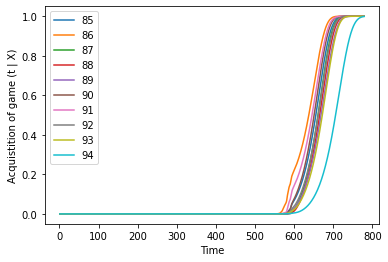

In [84]:
(1 - july_august_2022_survival.iloc[:, 85:95]) .plot()
plt.ylabel('Acquistition of game (t | X)')
_ = plt.xlabel('Time')

print(1 - july_august_2022_survival.loc[660].mean())
print((july_august_2022_survival.loc[660] <= 0.5).sum()*100 /july_august_2022_survival.shape[1])

## Prediction outputfor SnowFlake
For each player : median prediction time and two inflection points are sent in a table to SnowFlake

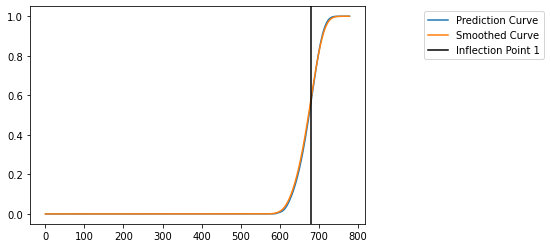

In [134]:
# ex pour un joueur
smooth = gaussian_filter1d((1-july_august_2022_survival[1300]), 10)
smooth_d2 = np.gradient(np.gradient(smooth))
inflection_points = np.where(np.diff(np.sign(smooth_d2)))[0]
plt.plot((1-july_august_2022_survival[1300]), label='Prediction Curve')
plt.plot(smooth, label='Smoothed Curve')
for i, infl in enumerate(inflection_points, 1):
    plt.axvline(x=infl, color='k', label=f'Inflection Point {i}')
plt.legend(bbox_to_anchor=(1.55, 1.0))

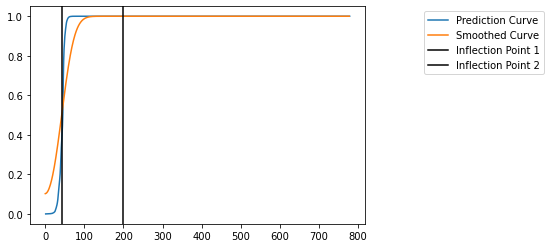

In [124]:
smooth = gaussian_filter1d((1-test_survival[400]), 25)
smooth_d2 = np.gradient(np.gradient(smooth))
inflection_points = np.where(np.diff(np.sign(smooth_d2)))[0]
plt.plot((1-test_survival[400]), label='Prediction Curve')
plt.plot(smooth, label='Smoothed Curve')
for i, infl in enumerate(inflection_points, 1):
    plt.axvline(x=infl, color='k', label=f'Inflection Point {i}')
plt.legend(bbox_to_anchor=(1.55, 1.0))

In [128]:
df_pred.loc[:,1:779]

,USER_KEY,CONV_LAST_OWNED,CONVERTED_VALHALLA,CONVERSION_DAYS_ACV,P2_POST_LAUNCH_ARRIVAL,NB_AC,PLAYED_ORIGINS,PLAYED_ODYSSEY,SENIORITY_AC,RECENCY_AC,...,774,775,776,777,778,779,pb_conv,pb_conv_moins1M,pb_conv_plus1M,pb_conv_plus10D
0,180073124,622,1,4,0,10.0,1.0,1.0,2274.0,65.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.234173,NaN,0.000075,0.017360
1,150066807,479,1,372,0,5.0,1.0,0.0,3096.0,2.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.556184,0.999725,0.000269,0.095037
2,278575808,14,0,599,0,5.0,1.0,0.0,2359.0,1668.0,...,1.423385e-04,1.097726e-04,8.405677e-05,6.389603e-05,4.820704e-05,3.609049e-05,0.998941,0.999977,0.966163,0.996072
3,153695731,773,0,599,0,1.0,1.0,0.0,936.0,265.0,...,2.513200e-11,1.203390e-11,5.642399e-12,2.589047e-12,1.161895e-12,5.096474e-13,0.972648,0.999547,0.858924,0.947919
4,278016363,507,1,32,0,8.0,1.0,1.0,1825.0,292.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.710384,0.998900,0.004634,0.424334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55380,2742678909,852,0,599,0,1.0,1.0,0.0,857.0,857.0,...,1.452150e-04,1.110233e-04,8.425841e-05,6.346300e-05,4.742920e-05,3.516381e-05,0.998633,0.999981,0.973518,0.995888
55381,2515370317,894,0,599,0,1.0,1.0,0.0,815.0,752.0,...,9.604396e-06,6.783598e-06,4.745553e-06,3.287271e-06,2.254179e-06,1.529762e-06,0.993893,0.999937,0.947553,0.987926
55382,3363041082,761,1,18,0,3.0,1.0,1.0,44.0,1.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.162202,NaN,0.000011,0.013625
55383,731612918,446,0,599,0,3.0,0.0,1.0,1794.0,698.0,...,7.618416e-17,2.513676e-17,8.032305e-18,2.483449e-18,7.422340e-19,2.142257e-19,0.966494,0.999820,0.790921,0.925384


In [125]:
def get_switching_point(x, smoothing_rate ):
    smooth = gaussian_filter1d(x, smoothing_rate)

    smooth_d2 = np.gradient(np.gradient(smooth))

    inflection_points = np.where(np.diff(np.sign(smooth_d2)))[0]
    return inflection_points[0]
    # plot results

    
df_pred['CONVERSION_RATE_INCREASE'] =  df_pred.apply(get_switching_point,  args=(30,), axis =1).astype(int)


RuntimeError: array type dtype('O') not supported

In [ ]:
# generate noisy data

#raw /= np.max(raw)
raw = rnd.lognormal(2,100)
raw = np.sort(raw/raw.max())

# smooth
smooth = gaussian_filter1d(raw, 40)

# compute second derivative
smooth_d2 = np.gradient(np.gradient(smooth))

# find switching points
infls = np.where(np.diff(np.sign(smooth_d2)))[0]

# plot results
plt.plot(raw, label='Prediction Curve')
plt.plot(smooth, label='Smoothed Curve')
#plt.plot(smooth_d2 / np.max(smooth_d2), label='Second Derivative (scaled)')
for i, infl in enumerate(infls, 1):
    plt.axvline(x=infl, color='k', label=f'Inflection Point {i}')
plt.legend(bbox_to_anchor=(1.55, 1.0))


In [ ]:
get_data(''' CREATE OR REPLACE TABLE SANDBOX.EMEA_ANALYTICS_CRM_PRIVATE.CS_AC_P2_PLAYERS_CONVERSION_ON_ACV_PREDICTIONS
             ( USER_KEY BIGINT ,
               MEDIAN_TIME DATE,
               CONVERSION_RATE_INCREASE DATE
             )''')

In [ ]:
with open("C:/Users/csouvigny/Documents/rsa_key/rsa_key.p8", "rb") as key:
    p_key= serialization.load_pem_private_key(
        key.read(),
        password='2B@XS5E&!5%UCab'.encode(),
    )

    pkb = p_key.private_bytes(
    encoding=serialization.Encoding.DER,
    format=serialization.PrivateFormat.PKCS8,
    encryption_algorithm=serialization.NoEncryption())

    engine = create_engine(URL(
        user='camille.souvigny@ubisoft.com',
        account='ubisoft.us-east-1',
        warehouse='EMEA_ANALYTICS_COMMON',
        database='SANDBOX',
        schema='EMEA_ANALYTICS_CRM_PRIVATE',
        role='SNK_F_EMEAANALYTICS_CRM_SB_DEV',
        proxy_host='http://proxy.ubisoft.org',
        proxy_port='3128'),
        connect_args={
        'private_key': pkb,
        }
    )
    
    with engine.connect() as con:
        start_time = datetime.now()
        df.to_sql( name = "CS_AC_P2_PLAYERS_CONVERSION_ON_ACV_PREDICTIONS", 
                         index = None,
                         con = con, if_exists='append', chunksize =16000)
        end_time = datetime.now()
        print('Duration: {}'.format(end_time - start_time))

## Linear Cox Time dependent

In [10]:
signif = ['CONVERSION_DAYS_ACV', 'CONVERTED_VALHALLA','P2_POST_LAUNCH_ARRIVAL', 'CONV_LAST_OWNED', 
          "P2_LAST_OWNED_ASSASSIN'S CREED ODYSSEY", 'NB_AC','PLAYED_ORIGINS', 'PLAYED_ODYSSEY',
          'SENIORITY_AC', 'RECENCY_AC', 'LIFETIME_AC', 'RECENCY_LAST_OWNED',
          'SENIORITY_LAST_OWNED', 'SENIORITY_P2', 'RECENCY_P2', 
          'NB_PD_P2', 'NB_PD_AC', 'NB_PD_AC_2021' , 'NB_PD_AC_2022',
          'NB_PD_LAST_OWNED', 'PROP_ACOD_AC', 'PROP_LEAST_AC', 'PROP_MOST_AC', 'AVG_PD_P2' , 
          'SENIORITY_WHEN_CONV_TO_LAST_OWNED', 'AVG_P2_LIFETIME',
          'MIN_P2_LIFETIME', 'MAX_P2_LIFETIME', 'MAX_LIFETIME_AC', 'MIN_LIFETIME_AC',
          'MIN_P2_ACQ_DELAY', 'MAX_P2_ACQ_DELAY', 'AVG_P2_ACQ_DELAY',
           'MIN_AC_ACQ_DELAY', 'MAX_AC_ACQ_DELAY','AVG_AC_ACQ_DELAY',
          'NB_GAMES', 'NB_BRANDS', 'NB_GAMES_2022', 'SENIORITY', 'RECENCY',
          'NB_PD', 'NB_GAMES_2022', 'NB_PD_2021', 'NB_PD_2022','PROP_SD_GAMES', 'PROP_LEAST_GAME',
          'PROP_MOST_GAME', 'AVG_LIFETIME' , 'MAX_P2_SD_10D', 'MIN_P2_SD_RATIO_10D', 'AVG_P2_SD_10D',
          'SD_LAST_OWNED_10D', 'PLAYTIME_LAST_OWNED_10D_RATIO', 'AVG_P2_SD_1M',
          'MIN_AC_SD_1M',  'MIN_PLAYTIME_10D_RATIO', 'AC_P2_DLC',
           'AVG_P2_SD_RATIO_1M', 'MIN_AC_SD_RATIO_1M','SUM_P2_PLAYTIME','MAX_P2_PLAYTIME_10D',
          'AVG_AC_PLAYTIME','SUM_AC_PLAYTIME','SUM_AC_PLAYTIME_10D','MAX_PLAYTIME_10D_RATIO',
          'NB_ACTIVATION_PASS','AC_P2_DLC','ESTIM_BG','ESTIM_NET_BG','PL_ACQUI','PL_NET_ACQUI' ,
          "P2_LAST_OWNED_ASSASSIN'S CREED ODYSSEY"
         ] 

In [11]:
start = datetime.now()
cox_time = CoxTimeVaryingFitter(penalizer=0.01)
cox_time.fit(df_train.drop(['USER_KEY','CLUSTER_2021','CLUSTER_2022'], axis=1)[signif], event_col='CONVERTED_VALHALLA', start_col='P2_POST_LAUNCH_ARRIVAL', stop_col='CONVERSION_DAYS_ACV', show_progress=True )
pickle.dump(cox_time, open( "/home/shared/csouvign/cox_time_varying.pickle", "wb" ) )
print(datetime.now() - start)

Iteration 1: norm_delta = 3.55554, step_size = 0.95000, ll = -4124982.17426, newton_decrement = 664218.08208, seconds_since_start = 791.7
Iteration 2: norm_delta = 1.20100, step_size = 0.95000, ll = -3594500.42384, newton_decrement = 83572.28263, seconds_since_start = 1582.6
Iteration 3: norm_delta = 0.33552, step_size = 0.95000, ll = -3509855.33860, newton_decrement = 5994.82333, seconds_since_start = 2372.1
Iteration 4: norm_delta = 0.10911, step_size = 1.00000, ll = -3502824.37166, newton_decrement = 1576.35425, seconds_since_start = 3161.6
Iteration 5: norm_delta = 0.02353, step_size = 1.00000, ll = -3500905.23936, newton_decrement = 405.84530, seconds_since_start = 3953.3
Iteration 6: norm_delta = 0.01662, step_size = 1.00000, ll = -3500404.67880, newton_decrement = 110.62567, seconds_since_start = 4743.0
Iteration 7: norm_delta = 0.01700, step_size = 1.00000, ll = -3500270.85961, newton_decrement = 20.79714, seconds_since_start = 5533.9
Iteration 8: norm_delta = 0.00529, step_siz

In [4]:
cox_time = pickle.load( open( "/home/shared/csouvign/cox_time_varying.pickle", "rb" ) )

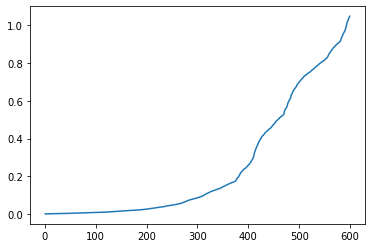

In [7]:
plt.plot(cox_time.baseline_cumulative_hazard_ , label='cox_time')

In [ ]:
tmp = pd.DataFrame(np.column_stack((ACtest.CONVERSION_DAYS_ACV, cox_time.predict_partial_hazard(ACtest))), columns =['CONVERSION_DAYS_ACV', 'partial_hazard'] )
plt.plot(tmp.groupby('CONVERSION_DAYS_ACV')['partial_hazard'].mean())

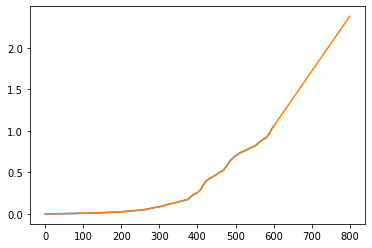

In [14]:
bas_cum_haz = cox_time.baseline_cumulative_hazard_
f = interpolate.interp1d(bas_cum_haz.index, bas_cum_haz['baseline hazard'], fill_value='extrapolate')

xnew = np.arange(1, 801, 1)
ynew = f(xnew)  
plt.plot(bas_cum_haz)
plt.plot(xnew, ynew)
plt.show()
base_cum_haz = pd.DataFrame(ynew, index=np.arange(1, 801, 1))

july_2022_survival = pd.DataFrame(np.exp(- np.dot(base_cum_haz , pd.DataFrame(cox_time.predict_partial_hazard(test_last_month[signif])).T)))

In [15]:
july_2022_survival.loc[700].mean()

0.8354002558525266

### Annexes : Output Analysis

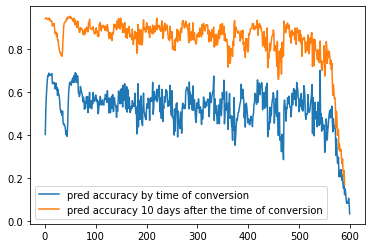

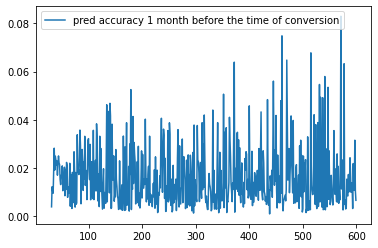

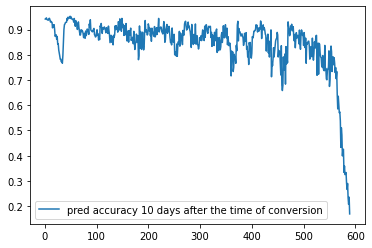

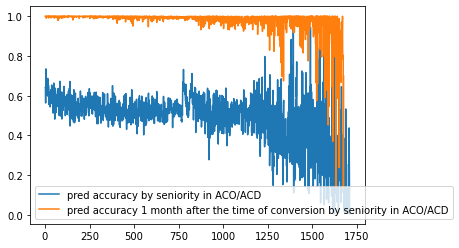

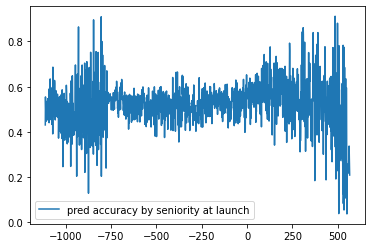

In [146]:
avg_prob_by_tend=pred_CoxNN.groupby('CONVERSION_DAYS_ACV')['pb_conv'].mean()
avg_prob_by_seniority_ac=pred_CoxNN[pred_CoxNN.CONVERTED_VALHALLA==1].groupby('SENIORITY_LAST_OWNED')['pb_conv'].mean()
avg_prob_by_seniority_at_launch=pred_CoxNN[pred_CoxNN.CONVERTED_VALHALLA==1].groupby(pred_CoxNN.CONVERSION_DAYS_ACV - pred_CoxNN.SENIORITY_LAST_OWNED)['pb_conv'].mean()

avg_prob_by_tendM1 = pred_CoxNN[pred_CoxNN.CONVERSION_DAYS_ACV>30].groupby('CONVERSION_DAYS_ACV')['pb_conv_moins1M'].mean()
avg_prob_by_seniority_acM1 = pred_CoxNN[pred_CoxNN.CONVERTED_VALHALLA==1][pred_CoxNN.CONVERSION_DAYS_ACV>30].groupby('SENIORITY_LAST_OWNED')['pb_conv_moins1M'].mean()
avg_prob_by_seniority_at_launchM1 = pred_CoxNN[pred_CoxNN.CONVERTED_VALHALLA==1][pred_CoxNN.CONVERSION_DAYS_ACV>30].groupby(pred_CoxNN.CONVERSION_DAYS_ACV - pred_CoxNN.SENIORITY_LAST_OWNED)['pb_conv_moins1M'].mean()

avg_prob_by_tendP10 = pred_CoxNN[pred_CoxNN.CONVERSION_DAYS_ACV<591].groupby('CONVERSION_DAYS_ACV')['pb_conv_plus10D'].mean()
avg_prob_by_seniority_acP10 = pred_CoxNN[pred_CoxNN.CONVERTED_VALHALLA==1][pred_CoxNN.CONVERSION_DAYS_ACV<591].groupby('SENIORITY_LAST_OWNED')['pb_conv_plus10D'].mean()
avg_prob_by_seniority_at_launchP10 = pred_CoxNN[pred_CoxNN.CONVERTED_VALHALLA==1][pred_CoxNN.CONVERSION_DAYS_ACV<591].groupby(pred_CoxNN.CONVERSION_DAYS_ACV - pred_CoxNN.SENIORITY_LAST_OWNED)['pb_conv_plus10D'].mean()

avg_prob_by_tendP1M = pred_CoxNN[pred_CoxNN.CONVERSION_DAYS_ACV<571].groupby('CONVERSION_DAYS_ACV')['pb_conv_plus1M'].mean()
avg_prob_by_seniority_acP1M = pred_CoxNN[pred_CoxNN.CONVERTED_VALHALLA==1][pred_CoxNN.CONVERSION_DAYS_ACV<571].groupby('SENIORITY_LAST_OWNED')['pb_conv_plus1M'].mean()
avg_prob_by_seniority_at_launchP1M = pred_CoxNN[pred_CoxNN.CONVERTED_VALHALLA==1][pred_CoxNN.CONVERSION_DAYS_ACV<571].groupby(pred_CoxNN.CONVERSION_DAYS_ACV - pred_CoxNN.SENIORITY_LAST_OWNED)['pb_conv_plus1M'].mean()

plt.plot(1- avg_prob_by_tend , label='pred accuracy by time of conversion')
plt.legend(loc="lower left") 
plt.show()

plt.plot(1- avg_prob_by_tendM1 , label='pred accuracy 1 month before the time of conversion')
plt.legend(loc="upper left")  
plt.show()

plt.plot(1- avg_prob_by_tendP10 , label='pred accuracy 10 days after the time of conversion')
plt.legend(loc="lower left")  
plt.show()

plt.plot(1- avg_prob_by_seniority_ac , label='pred accuracy by seniority in ACO/ACD')
plt.legend(loc="upper left")  

plt.plot(1- avg_prob_by_seniority_acP1M , label='pred accuracy 1 month after the time of conversion by seniority in ACO/ACD')
plt.legend(loc="lower left")  
plt.show()

plt.plot(1- avg_prob_by_seniority_at_launch , label='pred accuracy by seniority at launch')
plt.legend(loc="lower left")  
plt.show()


0.08616125163368338


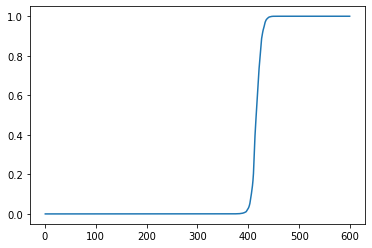

In [122]:
# low predictions on players who acquired last P2 AC early (avg 3 months of launch) and converted on back catalogue ACV (predict conversion later than should be)
print(1-pred_CoxNN[(pred_CoxNN.CONVERTED_VALHALLA==1) & (pred_CoxNN.SENIORITY_LAST_OWNED > 1500)].iloc[1].pb_conv)
plt.plot(1-pred_CoxNN[pred_CoxNN.columns[124:723]][(pred_CoxNN.CONVERTED_VALHALLA==1) & (pred_CoxNN.SENIORITY_LAST_OWNED > 1500)].iloc[1])

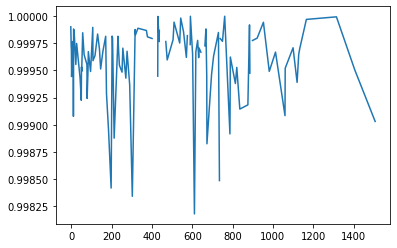

In [142]:
plt.plot(pred_CoxNN[(pred_CoxNN.CONVERTED_VALHALLA==1) & (pred_CoxNN.pb_conv>0.99)].groupby('CONV_LAST_OWNED')['pb_conv_moins1M'].mean())

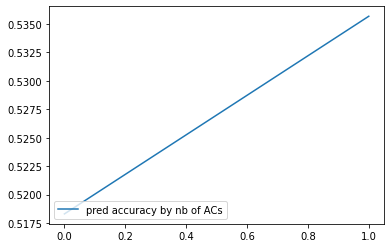

In [74]:
avg_prob_by_nb_ac=pred_CoxNN[pred_CoxNN.CONVERTED_VALHALLA==1].groupby('NB_AC')['pb_conv'].mean()
plt.plot((1-avg_prob_by_nb_ac), label='pred accuracy by nb of ACs')
plt.legend(loc="lower left")  
plt.show()

In [73]:
pred_CoxNN

,USER_KEY,CONV_LAST_OWNED,CONVERTED_VALHALLA,CONVERSION_DAYS_ACV,P2_POST_LAUNCH_ARRIVAL,NB_AC,PLAYED_ORIGINS,PLAYED_ODYSSEY,SENIORITY_AC,RECENCY_AC,...,594,595,596,597,598,599,pb_conv,pb_conv_moins1M,pb_conv_plus1M,pb_conv_plus10D
0,1980360553,86,1,360,0,1.0,0.0,1.0,1041.0,1014.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.940414,0.999090,1.434279e-04,0.582690
1,911610401,559,1,2,0,3.0,1.0,1.0,1112.0,24.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.243647,NaN,2.579074e-11,0.001033
2,3353871457,669,1,1,0,2.0,0.0,1.0,1674.0,99.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.716774,NaN,1.161785e-04,0.090635
3,3135397823,646,0,599,0,1.0,0.0,1.0,720.0,208.0,...,0.993003,0.992252,0.991596,0.990926,0.990268,0.989535,0.989535,0.999661,NaN,NaN
4,279648146,702,1,242,0,6.0,0.0,1.0,3761.0,193.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.701965,0.999642,1.471254e-04,0.205466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110713,3878418263,1003,0,599,237,2.0,0.0,1.0,371.0,315.0,...,0.995330,0.994671,0.994032,0.993312,0.992560,0.991678,0.991678,0.999527,NaN,NaN
110714,205248706,0,0,599,0,2.0,1.0,0.0,3056.0,1553.0,...,0.997764,0.997575,0.997410,0.997242,0.997076,0.996891,0.996891,0.999638,NaN,NaN
110715,291320619,15,1,107,0,8.0,1.0,1.0,2129.0,121.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.144422,0.986840,4.424528e-08,0.014100
110716,3247193273,740,0,599,0,1.0,0.0,1.0,626.0,95.0,...,0.996109,0.995570,0.995041,0.994427,0.993739,0.992881,0.992881,0.999537,NaN,NaN


### Impact metrics on predictions
- Lowerpredictions on players  

In [143]:
1/6 *100

16.666666666666664